
Simulate forcing ACL pathway in the NP11 model.And observe what happens with XPK. 
* You can  make a graph with flux of (phosphoketolase (fructose 6-phosphate)) on y axis and ACL on x axis, if you do forcing simulations in few steps. You will obtain like a linear line. 
* FBA params: I suggest Glc max at 0.05 GR and another round for 0.3 GR. 
* And extract cofactor balances, and compare how it changes when ACL is forced to have a flux. Especially NADH.



In [1]:
import cobra
import pandas as pd 
import os 
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt

In [2]:
# For getting IDs of all rxns
model1=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")

model1.objective = 'r_4041' # biomass
solution1 = model1.optimize()
all_fluxes = solution1.fluxes.to_frame(name='Flux')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-21


In [11]:
# Glc max at 0.05 GR and another round for 0.3 GR

# ACITL_c_bounds = [0.081856785,0.157705663,0.252251182,0.339119139,0.394261908,0.474691337]
# growth_rates = [0.049, 0.100, 0.151, 0.203, 0.25, 0.301]

glucose_uptakes = [0.476, 1.114, 1.648, 2.305, 3.1] 
all_fluxes_biomass_max = pd.DataFrame(columns=['Glucose uptake', 'Growth rate', *all_fluxes.index], index=range(len(glucose_uptakes))) #flux_values.index gives the row names column, * extracts the list of strings


for i in range(len(glucose_uptakes)):
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")
    # model.reactions.r_4041.bounds = growth_rates[i], growth_rates[i] 
    # model.reactions.y200003.bounds = ACITL_c_bounds[i], ACITL_c_bounds[i]
    model.reactions.r_1714.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])
    model.objective = 'r_4041'
    solution = model.optimize()
    all_fluxes_biomass_max.loc[i] = solution.fluxes[['r_1714', 'r_4041', *all_fluxes.index]].values
    
all_fluxes_biomass_max

In [4]:
# Exchange fluxes
exchange_fluxes_table = all_fluxes_biomass_max[['r_1714', 'r_1992', 'r_1654','r_2060','r_2005', 'r_1672']]

for i in range(len(exchange_fluxes_table.columns)):
    exchange_fluxes_table = exchange_fluxes_table.rename(columns = {exchange_fluxes_table.columns[i]: getattr(model.reactions, exchange_fluxes_table.columns[i]).name})

exchange_fluxes_table

,D-glucose exchange,oxygen exchange,ammonium exchange,sulphate exchange,phosphate exchange,carbon dioxide exchange
0,-0.476,-1.488248,-0.12617,-0.00261,-0.006745,1.588645
1,-1.114,-2.968506,-0.342739,-0.00709,-0.018323,3.241234
2,-1.648,-4.207467,-0.524006,-0.01084,-0.028013,4.624434
3,-2.305,-5.731808,-0.747026,-0.015453,-0.039936,6.326238
4,-3.1,-7.57633,-1.016889,-0.021035,-0.054363,8.385498


In [5]:
intracellular_fluxes = all_fluxes_biomass_max[['r_4046' ,'r_1714', 'r_0466', 'r_1049', 'r_1048','r_1050', 't_0081', 'r_0450','r_0959','r_0961', 'y200003']] # t_0081 - has only one phosphoketolase, not XPK and FPK separately

# Change G6PDH2rp column name to oxpp 

for i in range(len(intracellular_fluxes.columns)):
    intracellular_fluxes = intracellular_fluxes.rename(columns = {intracellular_fluxes.columns[i]: getattr(model.reactions, intracellular_fluxes.columns[i]).name})

intracellular_fluxes = intracellular_fluxes.rename(columns = {'glucose 6-phosphate dehydrogenase': 'oxPPP', 'non-growth associated maintenance reaction': 'NGAM'})
intracellular_fluxes


,NGAM,D-glucose exchange,oxPPP,transketolase 1,transaldolase,transketolase 2,phosphoketolase,fructose-bisphosphate aldolase,pyruvate decarboxylase,pyruvate dehydrogenase,ATP-citrate lyase
0,3.3928,-0.476,0.179927,0.041736,0.041736,0.03654,0.051289,0.274793,0.060672,0.463122,0.0
1,3.3928,-1.114,0.488772,0.113377,-0.454047,0.09926,0.139326,0.0,0.164815,0.899965,0.0
2,3.3928,-1.648,0.747272,0.173339,-0.639013,0.151757,0.213012,0.0,0.251983,1.265597,0.0
3,3.3928,-2.305,1.061065,0.251362,-0.875082,0.220594,0.286676,0.0,0.376223,1.702703,0.0
4,3.3928,-3.1,1.444376,0.342166,-1.153523,0.300284,0.390237,0.0,0.512133,2.24244,0.0


Text(0, 0.5, 'Flux $(g/gDW/h)$')

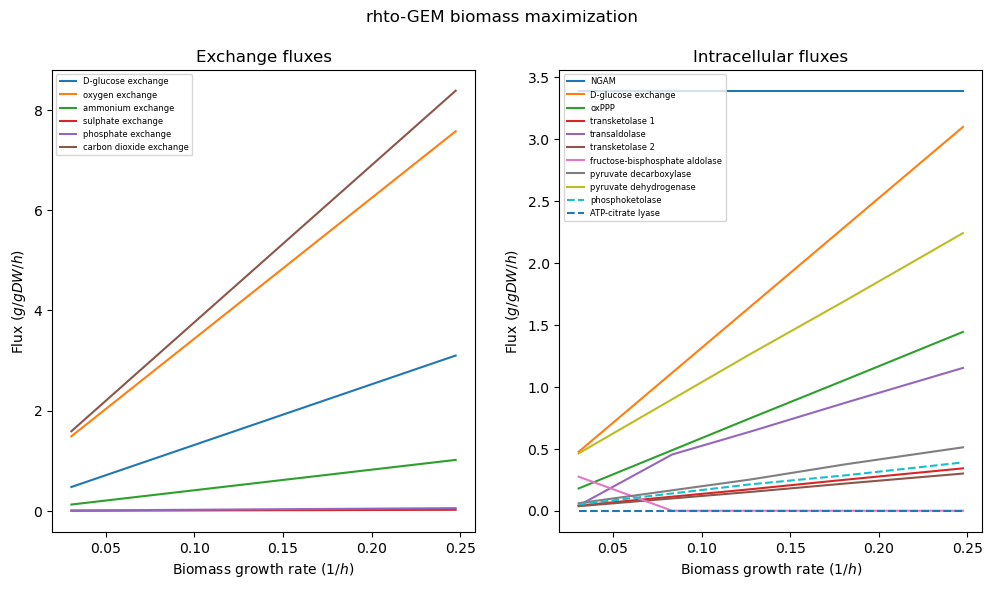

In [6]:
# Plot exchange and intracellular fluxes
fig, ax = plt.subplots(1, 2, figsize=(12,6)) #, 
fig.suptitle('rhto-GEM biomass maximization')

# Sample data

x1 = all_fluxes_biomass_max['r_4041']
y1 = np.abs(exchange_fluxes_table)

ax[0].plot(x1, y1, '-', label= y1.columns) #
ax[0].legend(fontsize=6, loc='upper left')
ax[0].set_title("Exchange fluxes") #fluxes biomass maximization
ax[0].set_xlabel('Biomass growth rate $(1/h)$')
ax[0].set_ylabel('Flux $(g/gDW/h)$')

x2 = all_fluxes_biomass_max['r_4041']
y2 = np.abs(intracellular_fluxes.drop(columns = ['phosphoketolase','ATP-citrate lyase']))
y3 = np.abs(intracellular_fluxes[['phosphoketolase','ATP-citrate lyase']])

ax[1].plot(x2, y2, '-', label= y2.columns) #
ax[1].plot(x2, y3, '--', label= y3.columns) # ACL and phosphoketolase

ax[1].legend(fontsize=6, loc='upper left')
ax[1].set_title("Intracellular fluxes")
ax[1].set_xlabel('Biomass growth rate $(1/h)$')
ax[1].set_ylabel('Flux $(g/gDW/h)$')

COFACTOR BALANCES

In [5]:
# Cofactor lists
nadphs = ['s_1212', 's_1213', 's_1214', 's_1215', 's_2799','s_2952']
nadhs = ['s_1203', 's_1204', 's_1205', 's_1206', 's_1206', 's_3753']
atps = ['s_0434', 's_0435', 's_0437', 's_3881', 's_0438', 's_0439', 's_3359', 's_2840', 's_2831', 's_2856', 's_3341'] 

# Make a function for getting cofactor fluxes (all reactions where given metabolite is and their fluxes)

def cofactor_all_rxn_fluxes(cofactor_list, i):
    glucose_uptakes = [0.476, 1.114, 1.648, 2.305, 3.1] 

    producing_fluxes = pd.DataFrame() 
    consuming_fluxes = pd.DataFrame()
    
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")   
    model.reactions.r_1714.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])
    model.objective = 'r_4041' # biomass rxn
    solution = model.optimize()

    for metabolite in cofactor_list:
        producing_fluxes = pd.concat([producing_fluxes, getattr(model.metabolites, metabolite).summary().producing_flux])
        consuming_fluxes = pd.concat([consuming_fluxes, getattr(model.metabolites, metabolite).summary().consuming_flux])
    
    for reaction in producing_fluxes.index:
        if reaction in consuming_fluxes.index and abs(round(producing_fluxes.loc[reaction, 'flux'], 3)) == abs(round(consuming_fluxes.loc[reaction, 'flux'], 3)):
            producing_fluxes = producing_fluxes.drop([reaction])
            consuming_fluxes = consuming_fluxes.drop([reaction])
            
    cofactor_fluxes = pd.concat([producing_fluxes, consuming_fluxes])

    cofactor_fluxes = cofactor_fluxes.sort_values(by='flux', ascending=False).drop(columns = ['percent']) # drop percent column, bc these percents are not for nadph sum (the percent is for specific compartment)
    cofactor_fluxes = cofactor_fluxes[(cofactor_fluxes['flux']) != 0.0] # for getting non-zero fluxes only

    cofactor_sum_producing_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] > 0]['flux']) # for getting the sum of producing fluxes
    cofactor_sum_consuming_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] < 0]['flux']) # for getting the sum of consumed fluxes
    print(f'SUM produced: {cofactor_sum_producing_flux}, SUM consumed: {cofactor_sum_consuming_flux}')

    if round(cofactor_sum_producing_flux, 3) == round(abs(cofactor_sum_consuming_flux), 3):
        cofactor_fluxes['percent'] = abs(cofactor_fluxes['flux']/cofactor_sum_producing_flux) # add percent column

    return cofactor_fluxes

# Making a pie chart
def cofactor_fluxes_pie_chart(cofactor_fluxes,  title): 
    threshold = 0.05 # threshold shows the percent of the flux for including in others sector on pie chart 
    # The three lines below are for grouping together reactions with low fluxes in producing
    producing_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] > 0).copy()]    
    producing_cofactor_fluxes_draw.loc[producing_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other producing'
    producing_cofactor_fluxes_draw = producing_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()        
    
    # The three lines below are for grouping together reactions with low fluxes in consuming 
    consuming_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] < 0).copy()]
    consuming_cofactor_fluxes_draw.loc[consuming_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other consuming'
    consuming_cofactor_fluxes_draw = consuming_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()
    
    # y_producing = producing_cofactor_fluxes_draw['percent']
    # labels_producing = producing_cofactor_fluxes_draw[['reaction', 'flux']] 
    
    # y_consuming = abs(consuming_cofactor_fluxes_draw['percent'])
    # labels_consuming = consuming_cofactor_fluxes_draw[['reaction', 'flux']]
    
    producing_and_consuming_fluxes = pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])
    
    # reaction_IDs = pd.concat([labels_producing, labels_consuming])
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")   
    model.objective = 'r_1714'
    solution = model.optimize()
    
    reaction_names_w_flux = []
    for reaction in producing_and_consuming_fluxes.index:
        if reaction != 'Other producing' and reaction != 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), getattr(model.reactions, reaction).name,' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])]
        elif reaction == 'Other producing':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other producing', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
        elif reaction == 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other consuming', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
    fig = plt.figure()
        
    pie_chart = plt.pie(producing_and_consuming_fluxes.loc[:, 'percent'], labels = reaction_names_w_flux)  #autopct='%1.1f%%' pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])[['flux', 'percent']]
    # plt.title(title)
    

    
    return pie_chart, fig


In [6]:
# Get nadph fluxes at lowest biomass growth rate

nadph_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadphs, 0)
nadph_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

nadph_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadphs, 4)
nadph_fluxes_highest_GR

# Get nadh fluxes at lowest biomass growth rate

nadh_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadhs, 0)
nadh_fluxes_lowest_GR

# Get nadh fluxes at highest biomass growth rate

nadh_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadhs, 4)
nadh_fluxes_highest_GR

# Get atp fluxes at lowest biomass growth rate

atp_fluxes_lowest_GR = cofactor_all_rxn_fluxes(atps, 0)
atp_fluxes_lowest_GR

# Get atp fluxes at highest biomass growth rate

atp_fluxes_highest_GR = cofactor_all_rxn_fluxes(atps, 4)
atp_fluxes_highest_GR

SUM produced: 0.3932994473877962, SUM consumed: -0.39329944738779626
SUM produced: 3.169873231565297, SUM consumed: -3.1698732315652967
SUM produced: 3.2716714977963197, SUM consumed: -3.2716714977963197
SUM produced: 17.531696578782938, SUM consumed: -17.531696578782938
SUM produced: 8.815819758881732, SUM consumed: -8.815819758881728
SUM produced: 45.627831148790314, SUM consumed: -45.62783114879031


,flux,reaction,percent
r_0226,36.531805,r_0226,0.800647
r_0892,3.648863,r_0892,0.079970
r_0962,3.328436,r_0962,0.072947
r_1022,1.914861,r_1022,0.041967
r_0447,0.200897,r_0447,0.004403
...,...,...,...
r_0886,-1.141956,r_0886,0.025028
r_0148,-1.342426,r_0148,0.029421
r_0534,-3.100000,r_0534,0.067941
r_4046,-3.392800,r_4046,0.074358


In [19]:
# import pickle

# with open("../cofactor_comparison/rhtoGEM_cofactors.pk", "wb") as f:
#     pickle.dump([nadph_fluxes_lowest_GR, nadph_fluxes_highest_GR, nadh_fluxes_lowest_GR, nadh_fluxes_highest_GR, atp_fluxes_lowest_GR, atp_fluxes_highest_GR], f)

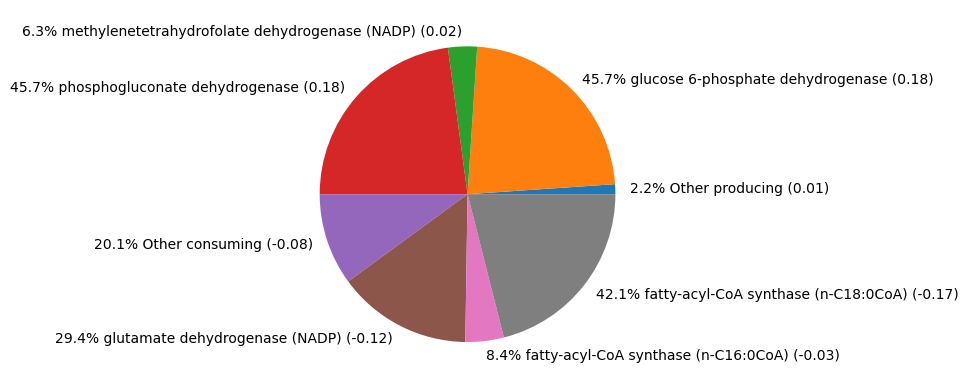

In [12]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'rhto-GEM NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadph_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title)
producing_nadph_fluxes_lowest_GR_pie_chart

fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\rhtoGEM_bm_NADPH.png")

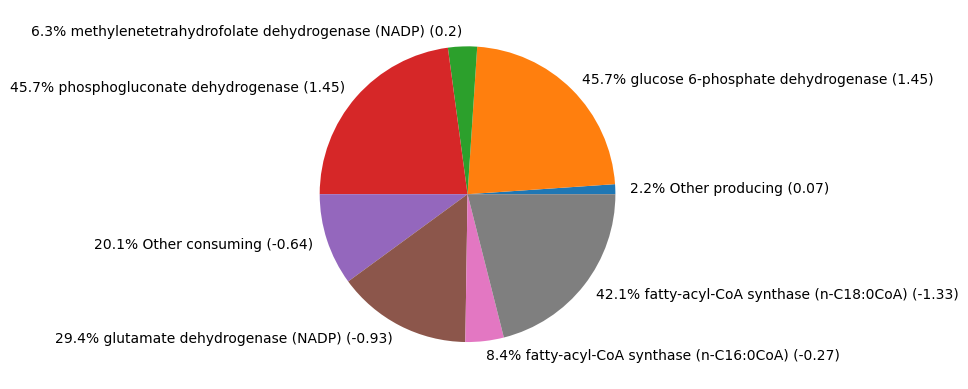

In [13]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'rhto-GEM NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadph_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadph_fluxes_highest_GR, title)
producing_nadph_fluxes_highest_GR_pie_chart

fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\rhtoGEM_bm_NADPH_max.png")


([<matplotlib.patches.Wedge at 0x29564a7ca10>,
 [Text(1.096789648009145, 0.0839789736777976, '4.9% Other producing (0.16)'),
  Text(0.9866618595193613, 0.48631098586171834, '19.4% glyceraldehyde-3-phosphate dehydrogenase (0.64)'),
  Text(0.6264958194420807, 0.9041587184900647, '12.8% glycine-cleavage complex (lipoamide) (0.42)'),
  Text(0.20995429375518632, 1.0797773819328507, '13.5% isocitrate dehydrogenase (NAD+) (0.44)'),
  Text(-0.596434328487278, 0.9242651631441758, '35.2% malate dehydrogenase (1.15)'),
  Text(-1.0729190775725255, 0.2425791684809753, '14.2% pyruvate dehydrogenase (0.46)'),
  Text(-1.099898400125349, -0.014950230824249067, '0.9% Other consuming (-0.03)'),
  Text(-1.0213152734346487, -0.4085524596047722, '22.5% malate dehydrogenase, cytoplasmic (-0.74)'),
  Text(0.39463390541099264, -1.0267736268039163, '76.6% NADH dehydrogenase (complex I) (-2.51)')])

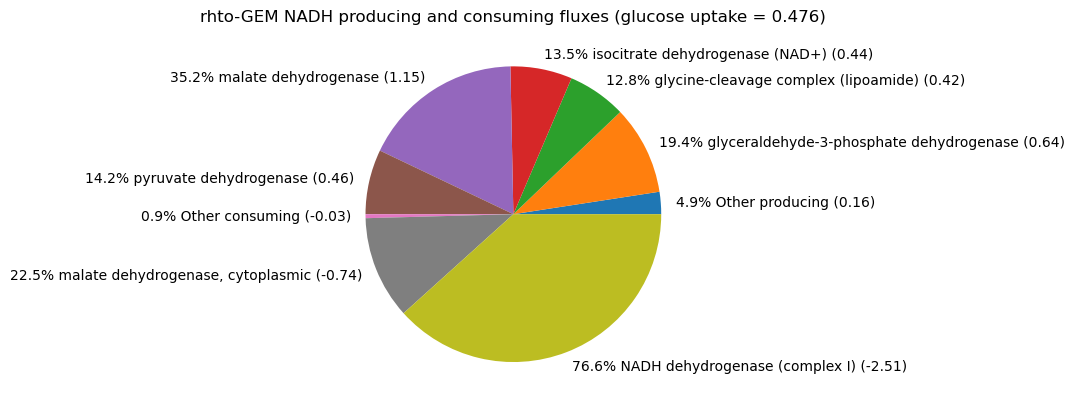

In [11]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'rhto-GEM NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadh_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadh_fluxes_lowest_GR, title, threshold)
producing_nadh_fluxes_lowest_GR_pie_chart

([<matplotlib.patches.Wedge at 0x2956570f770>,
 [Text(1.0972188383945043, 0.07817173832156234, '4.5% Other producing (0.79)'),
  Text(0.9811336195556319, 0.4973699031683207, '20.8% glyceraldehyde-3-phosphate dehydrogenase (3.65)'),
  Text(0.6239371871994268, 0.9059262588255557, '10.9% glycine-cleavage complex (lipoamide) (1.91)'),
  Text(0.2662917793069112, 1.0672809790648194, '11.9% isocitrate dehydrogenase (NAD+) (2.09)'),
  Text(-0.5373576993031728, 0.9598159735072141, '36.2% malate dehydrogenase (6.34)'),
  Text(-1.0540374725439403, 0.3146506101586052, '12.9% pyruvate dehydrogenase (2.26)'),
  Text(-1.098944394339749, 0.048179021879265094, '2.8% acetaldehyde dehydrogenase (0.49)'),
  Text(-1.09977016781538, -0.02248506133705736, '1.3% Other consuming (-0.23)'),
  Text(-0.9950508648828654, -0.4689070017560642, '25.4% malate dehydrogenase, cytoplasmic (-4.46)'),
  Text(0.4484691984887719, -1.0044278859165743, '73.3% NADH dehydrogenase (complex I) (-12.84)')])

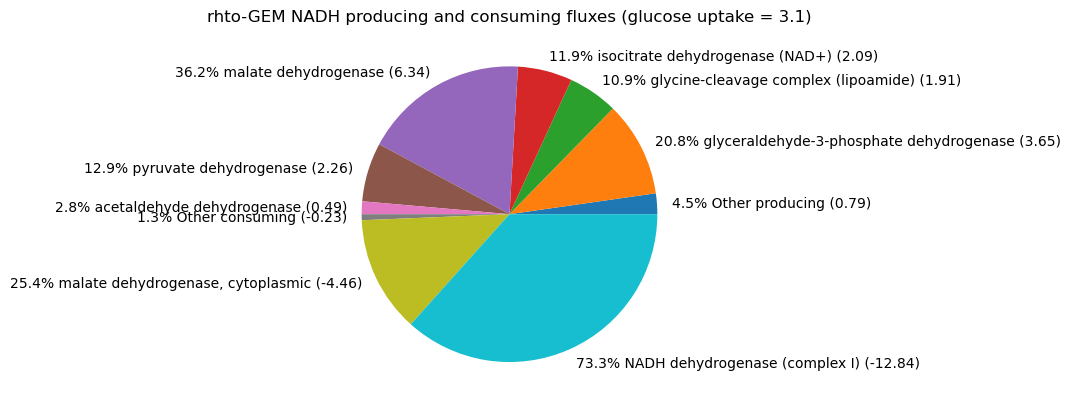

In [12]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'rhto-GEM NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadh_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadh_fluxes_highest_GR, title, threshold)
producing_nadh_fluxes_highest_GR_pie_chart


([<matplotlib.patches.Wedge at 0x295675d6300>,
 [Text(1.0999888279467414, 0.0049576599676271135, '0.3% Other producing (0.03)'),
  Text(0.3142916759369729, 1.0541445548105484, '81.0% ATP synthase (7.14)'),
  Text(-0.9780704242319221, 0.5033669091654596, '7.2% phosphoglycerate kinase (0.64)'),
  Text(-1.0641710989777706, 0.27845982133953184, '6.8% pyruvate kinase (0.6)'),
  Text(-1.0969165035613673, 0.0823054324738353, '4.8% succinate-CoA ligase (ADP-forming) (0.42)'),
  Text(-1.0906590775591922, -0.14304816160206985, '8.3% Other consuming (-0.73)'),
  Text(-1.0349449076901758, -0.3726781963654083, '5.4% hexokinase (D-glucose:ATP) (-0.48)'),
  Text(-0.9797374558667803, -0.5001145044604173, '2.6% phosphofructokinase (-0.23)'),
  Text(-0.37488667906631573, -1.0341469807810828, '45.2% biomass pseudoreaction (-3.98)'),
  Text(0.905048566479601, -0.6252096386918705, '38.5% non-growth associated maintenance reaction (-3.39)')])

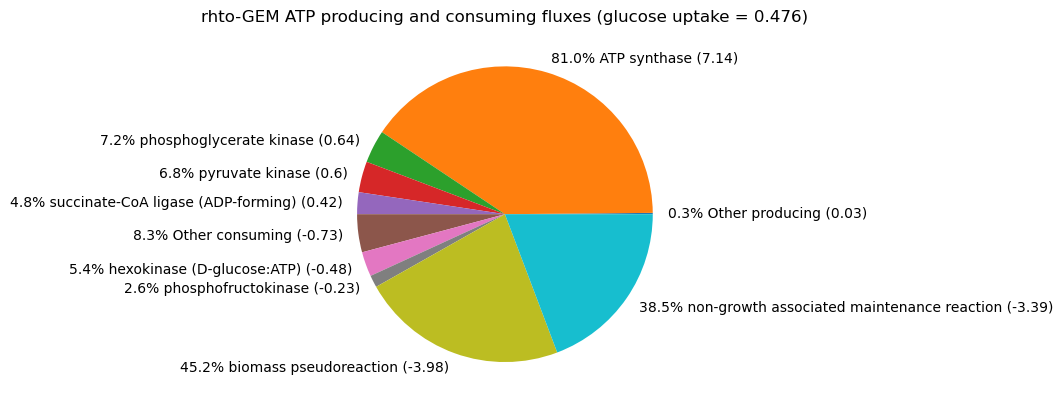

In [13]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'rhto-GEM ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_atp_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(atp_fluxes_lowest_GR, title,  threshold)
producing_atp_fluxes_lowest_GR_pie_chart

([<matplotlib.patches.Wedge at 0x29568267ad0>,
 [Text(1.0999729084373366, 0.007720149215298765, '0.4% Other producing (0.2)'),
  Text(0.32413231468092496, 1.0511604266616899, '80.1% ATP synthase (36.53)'),
  Text(-0.9723045033265728, 0.514416128062551, '8.0% phosphoglycerate kinase (3.65)'),
  Text(-1.066768677358327, 0.2683367082737018, '7.3% pyruvate kinase (3.33)'),
  Text(-1.097610732224525, 0.07246157951316096, '4.2% succinate-CoA ligase (ADP-forming) (1.91)'),
  Text(-1.0864936869598436, -0.17184722341779568, '10.0% Other consuming (-4.56)'),
  Text(-1.0295059886368734, -0.38744989270977254, '2.9% adenylate kinase (-1.34)'),
  Text(-0.9584652495080512, -0.539763249476536, '6.8% hexokinase (D-glucose:ATP) (-3.1)'),
  Text(-0.8697189151271078, -0.6734901696907885, '2.5% phosphofructokinase (-1.14)'),
  Text(0.25325418098191044, -1.070449587703775, '70.3% biomass pseudoreaction (-32.09)'),
  Text(1.092505015748784, -0.12819044646052813, '7.4% non-growth associated maintenance reacti

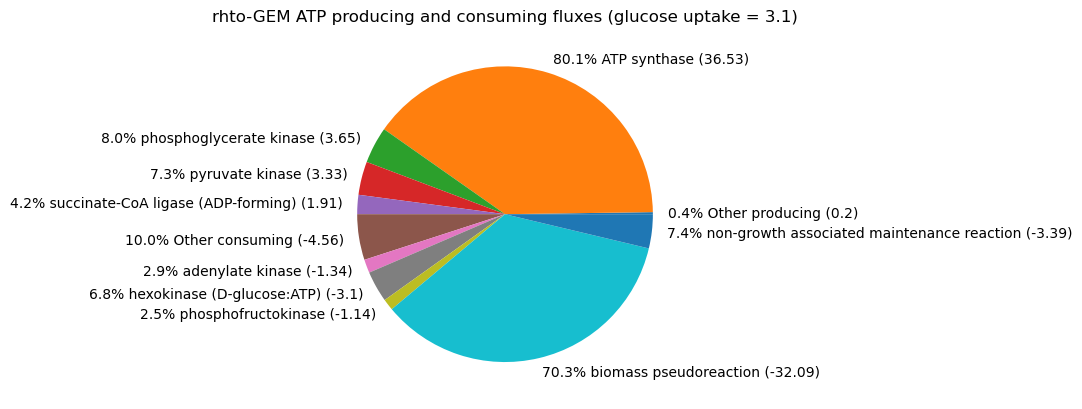

In [14]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'rhto-GEM ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_atp_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(atp_fluxes_highest_GR, title,  threshold)
producing_atp_fluxes_highest_GR_pie_chart

In [15]:
# # Get all fluxes to excel

# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\NP11\\NP11_fluxes_glc_max_forced_ACITL.xlsx') as excel_writer:
#     all_fluxes_glc_max.to_excel(excel_writer, sheet_name='Glucose max', index=True)

In [16]:
# # # #  Get csv files
# glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 2.6619851, 3.1]
# i = 2
# all_fluxes_biomass_max.loc[i].to_csv(f'C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\NP11\\biomass_max_glucose_uptake_{glucose_uptakes[i]}.csv', index=True)



In [17]:
# # Get json file
# filename = f'C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\NP11\\NP11json.json'
# cobra.io.save_json_model(model1, filename, pretty=False)

In [18]:
# # Get cofactor data to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\NP11\\NP11_cofactor_fluxes_forced_ACITL.xlsx') as excel_writer:
#     nadph_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {growth_rates[0]}', index=False)
#     nadph_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {growth_rates[5]}', index=False)
#     nadh_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {growth_rates[0]}', index=False)
#     nadh_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {growth_rates[5]}', index=False)
#     atp_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {growth_rates[0]}', index=False)
#     atp_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {growth_rates[5]}', index=False)